In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


※此程式碼僅負責畫圖部分

## 2.(a) 查看台灣島嶼輪廓 可視化比較logistic regression 跟random forest

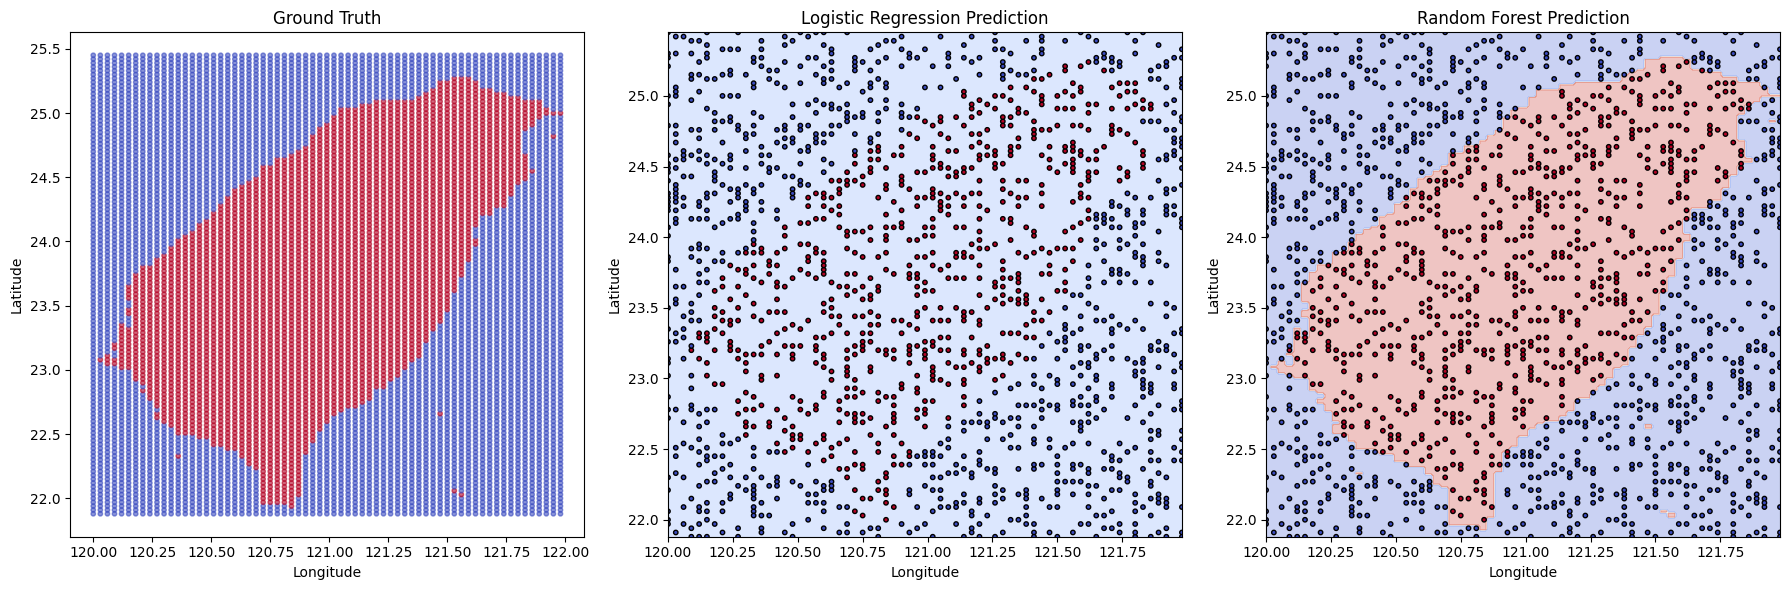

In [3]:
df_cls = pd.read_csv("classification_dataset.csv")
X = df_cls[["lon", "lat"]].values
y = df_cls["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Logistic model vs. random forest
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


lon_min, lon_max = X[:,0].min(), X[:,0].max()
lat_min, lat_max = X[:,1].min(), X[:,1].max()
xx, yy = np.meshgrid(
    np.linspace(lon_min, lon_max, 200),
    np.linspace(lat_min, lat_max, 200)
)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# --- Logistic model vs. random forest
Z_log = log_reg.predict(grid_points).reshape(xx.shape)
Z_rf = rf.predict(grid_points).reshape(xx.shape)

# --- 繪圖 ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1) 真實資料
axes[0].scatter(X[:,0], X[:,1], c=y, cmap="coolwarm", s=10, alpha=0.6)
axes[0].set_title("Ground Truth")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

# 2) Logistic Regression decision boundary
axes[1].contourf(xx, yy, Z_log, cmap="coolwarm", alpha=0.3)
axes[1].scatter(X_test[:,0], X_test[:,1], c=y_test, cmap="coolwarm", s=10, edgecolor="k")
axes[1].set_title("Logistic Regression Prediction")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")

# 3) Random Forest decision boundary
axes[2].contourf(xx, yy, Z_rf, cmap="coolwarm", alpha=0.3)
axes[2].scatter(X_test[:,0], X_test[:,1], c=y_test, cmap="coolwarm", s=10, edgecolor="k")
axes[2].set_title("Random Forest Prediction")
axes[2].set_xlabel("Longitude")
axes[2].set_ylabel("Latitude")

plt.tight_layout()
plt.show()


# Visualization for 2.(b): Linear vs RandomForest vs KNN vs SVR

Linear        MAE=4.399  RMSE=5.669
RandomForest  MAE=1.517  RMSE=2.281
KNN           MAE=1.463  RMSE=2.178
SVR(RBF)      MAE=2.170  RMSE=3.244


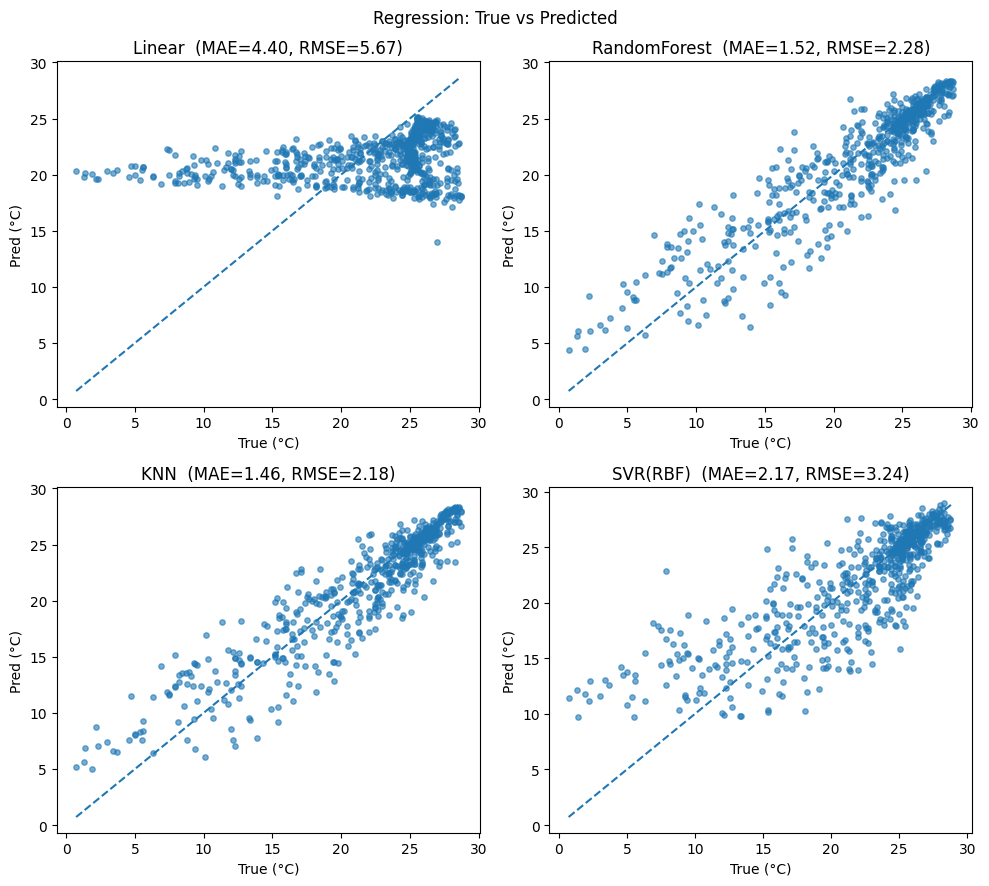

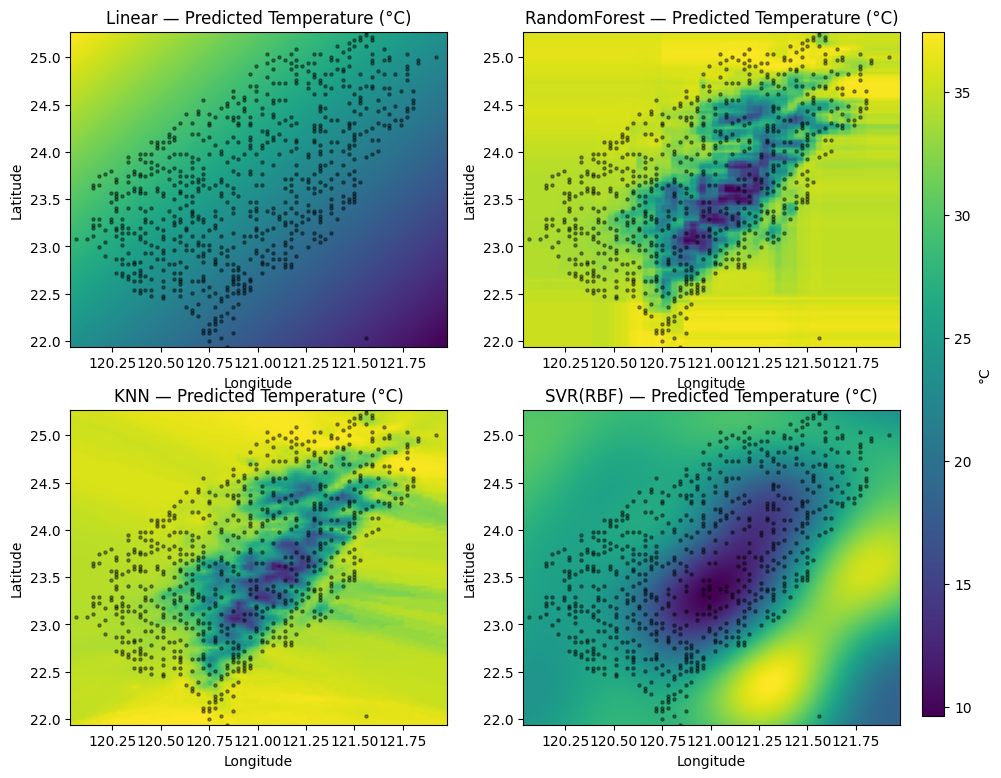

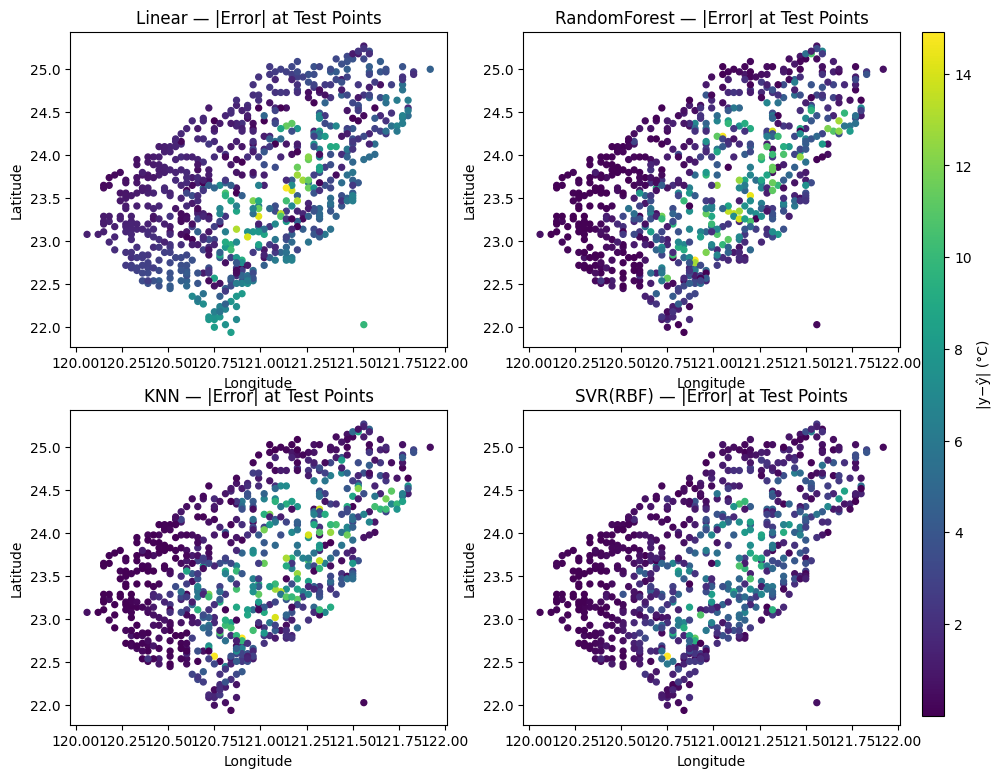

In [6]:
# -*- coding: utf-8 -*-

# Needs: numpy, pandas, scikit-learn, matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# ---------- 讀資料 ----------
df = pd.read_csv("regression_dataset.csv")   # columns: lon, lat, value
X = df[["lon","lat"]].values
y = df["value"].values

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------- 建四個模型 ----------
models = {
    "Linear": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        n_estimators=300, min_samples_leaf=2, random_state=42, n_jobs=-1
    ),
    "KNN": KNeighborsRegressor(n_neighbors=9, weights="distance"),
    "SVR(RBF)": make_pipeline(StandardScaler(), SVR(kernel="rbf", C=10.0, epsilon=0.2))
}

preds = {}
metrics = {}

def RMSE(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

for name, model in models.items():
    model.fit(X_tr, y_tr)
    p = model.predict(X_te)
    preds[name] = p
    mae = mean_absolute_error(y_te, p)
    rmse = RMSE(y_te, p)
    metrics[name] = (mae, rmse)
    print(f"{name:12s}  MAE={mae:.3f}  RMSE={rmse:.3f}")

# ---------- 1) True vs Predicted (四宮格) ----------
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
axes = axes.ravel()
for ax, (name, p) in zip(axes, preds.items()):
    ax.scatter(y_te, p, s=15, alpha=0.6)
    lo, hi = min(y_te.min(), p.min()), max(y_te.max(), p.max())
    ax.plot([lo, hi], [lo, hi], linestyle="--")  # y=x
    mae, rmse = metrics[name]
    ax.set_title(f"{name}  (MAE={mae:.2f}, RMSE={rmse:.2f})")
    ax.set_xlabel("True (°C)")
    ax.set_ylabel("Pred (°C)")
fig.suptitle("Regression: True vs Predicted", y=0.98)
fig.tight_layout()
plt.show()

# ---------- 2) 經緯度網格上的「預測溫度熱圖」 ----------
# 建網格（覆蓋資料範圍）
lon_min, lon_max = X[:,0].min(), X[:,0].max()
lat_min, lat_max = X[:,1].min(), X[:,1].max()
gx, gy = np.meshgrid(
    np.linspace(lon_min, lon_max, 120),
    np.linspace(lat_min, lat_max, 120)
)
grid_pts = np.c_[gx.ravel(), gy.ravel()]

fig, axes = plt.subplots(2, 2, figsize=(11, 9))
axes = axes.ravel()
for ax, (name, model) in zip(axes, models.items()):
    gpred = model.predict(grid_pts).reshape(gx.shape)
    im = ax.imshow(
        gpred, origin="lower",
        extent=[lon_min, lon_max, lat_min, lat_max],
        aspect="auto"
    )
    ax.scatter(X_te[:,0], X_te[:,1], c="k", s=5, alpha=0.4)  # 標記測試點位置
    ax.set_title(f"{name} — Predicted Temperature (°C)")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
fig.subplots_adjust(right=0.88)
cax = fig.add_axes([0.90, 0.12, 0.02, 0.76])
fig.colorbar(im, cax=cax, label="°C")
plt.show()

# ---------- 3) 測試點的「絕對誤差空間圖」 ----------
fig, axes = plt.subplots(2, 2, figsize=(11, 9))
axes = axes.ravel()
for ax, (name, p) in zip(axes, preds.items()):
    err = np.abs(y_te - p)
    sc = ax.scatter(X_te[:,0], X_te[:,1], c=err, s=18)
    ax.set_title(f"{name} — |Error| at Test Points")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
fig.subplots_adjust(right=0.88)
cax = fig.add_axes([0.90, 0.12, 0.02, 0.76])
fig.colorbar(sc, cax=cax, label="|y−ŷ| (°C)")
plt.show()
